In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [34]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([x1_merge1, x1])

x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)

x1_merge3 = concatenate([x1_merge2, x1])

x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)



# 4 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x2_merge1 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)

x2_merge2 = concatenate([x2_merge1, x2])

x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)

x2_merge3 = concatenate([x2_merge2, x2])

x2 = layers.Conv1D(filters=16, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge3)


merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)

ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 72, 256)      14592       input_3[0][0]                    
__________________________________________________________________________________________________
simple_rnn_6 (SimpleRNN)        (None, 72, 128)      20096       input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 72, 284)      0           input_3[0][0]                    
                                                                 conv1d_10[0][0]            

Epoch 1/8000


2023-01-01 23:55:45.152831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-01 23:55:45.386395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-01 23:55:46.677105: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-01 23:55:47.178342: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.05460, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 92s - loss: 0.0880 - mae: 0.0609 - val_loss: 0.0514 - val_mae: 0.0546
Epoch 2/8000

Epoch 00002: val_mae improved from 0.05460 to 0.04126, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 21s - loss: 0.0350 - mae: 0.0311 - val_loss: 0.0264 - val_mae: 0.0413
Epoch 3/8000

Epoch 00003: val_mae improved from 0.04126 to 0.03699, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 21s - loss: 0.0195 - mae: 0.0230 - val_loss: 0.0165 - val_mae: 0.0370
Epoch 4/8000

Epoch 00004: val_mae improved from 0.03699 to 0.03332, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 22s - loss: 0.0123 - mae: 0.0193 - val_loss: 0.0111 - val_mae: 0.0333
Epoch 5/8000

Epoch 00005: val_mae improved from 0.03332 to 0.03066, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 22s - loss: 0.0083 - mae: 0.0171 - val_loss: 0.0079 

Epoch 46/8000

Epoch 00046: val_mae did not improve from 0.01578
151/151 - 21s - loss: 3.1237e-04 - mae: 0.0086 - val_loss: 6.8052e-04 - val_mae: 0.0176
Epoch 47/8000

Epoch 00047: val_mae did not improve from 0.01578
151/151 - 21s - loss: 3.1148e-04 - mae: 0.0085 - val_loss: 6.0446e-04 - val_mae: 0.0160
Epoch 48/8000

Epoch 00048: val_mae did not improve from 0.01578
151/151 - 21s - loss: 3.1050e-04 - mae: 0.0085 - val_loss: 6.5643e-04 - val_mae: 0.0172
Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01578
151/151 - 21s - loss: 3.1026e-04 - mae: 0.0085 - val_loss: 6.3872e-04 - val_mae: 0.0167
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01578
151/151 - 21s - loss: 3.0917e-04 - mae: 0.0085 - val_loss: 5.9478e-04 - val_mae: 0.0160
Epoch 51/8000

Epoch 00051: val_mae did not improve from 0.01578
151/151 - 21s - loss: 3.1217e-04 - mae: 0.0086 - val_loss: 6.0263e-04 - val_mae: 0.0160
Epoch 52/8000

Epoch 00052: val_mae did not improve from 0.01578
151/151 - 21s - l

Epoch 97/8000

Epoch 00097: val_mae did not improve from 0.01375
151/151 - 21s - loss: 2.8598e-04 - mae: 0.0079 - val_loss: 5.2022e-04 - val_mae: 0.0145
Epoch 98/8000

Epoch 00098: val_mae did not improve from 0.01375
151/151 - 21s - loss: 2.8563e-04 - mae: 0.0079 - val_loss: 5.1963e-04 - val_mae: 0.0147
Epoch 99/8000

Epoch 00099: val_mae did not improve from 0.01375
151/151 - 21s - loss: 2.8956e-04 - mae: 0.0081 - val_loss: 5.5265e-04 - val_mae: 0.0152
Epoch 100/8000

Epoch 00100: val_mae did not improve from 0.01375
151/151 - 21s - loss: 2.8613e-04 - mae: 0.0079 - val_loss: 5.2554e-04 - val_mae: 0.0147
Epoch 101/8000

Epoch 00101: val_mae did not improve from 0.01375
151/151 - 21s - loss: 2.8653e-04 - mae: 0.0080 - val_loss: 5.6569e-04 - val_mae: 0.0152
Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.01375
151/151 - 21s - loss: 2.8660e-04 - mae: 0.0080 - val_loss: 5.5098e-04 - val_mae: 0.0154
Epoch 103/8000

Epoch 00103: val_mae did not improve from 0.01375
151/151 - 21s

Epoch 150/8000

Epoch 00150: val_mae did not improve from 0.01330
151/151 - 21s - loss: 2.7518e-04 - mae: 0.0077 - val_loss: 5.5001e-04 - val_mae: 0.0151
Epoch 151/8000

Epoch 00151: val_mae did not improve from 0.01330
151/151 - 21s - loss: 2.7490e-04 - mae: 0.0077 - val_loss: 5.3802e-04 - val_mae: 0.0150
Epoch 152/8000

Epoch 00152: val_mae did not improve from 0.01330
151/151 - 21s - loss: 2.7363e-04 - mae: 0.0076 - val_loss: 4.8844e-04 - val_mae: 0.0140
Epoch 153/8000

Epoch 00153: val_mae did not improve from 0.01330
151/151 - 21s - loss: 2.7812e-04 - mae: 0.0078 - val_loss: 5.4339e-04 - val_mae: 0.0147
Epoch 154/8000

Epoch 00154: val_mae did not improve from 0.01330
151/151 - 21s - loss: 2.7100e-04 - mae: 0.0075 - val_loss: 4.9104e-04 - val_mae: 0.0141
Epoch 155/8000

Epoch 00155: val_mae did not improve from 0.01330
151/151 - 21s - loss: 2.7357e-04 - mae: 0.0076 - val_loss: 4.9619e-04 - val_mae: 0.0143
Epoch 156/8000

Epoch 00156: val_mae did not improve from 0.01330
151/151 - 

Epoch 203/8000

Epoch 00203: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6852e-04 - mae: 0.0075 - val_loss: 4.5600e-04 - val_mae: 0.0132
Epoch 204/8000

Epoch 00204: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6643e-04 - mae: 0.0075 - val_loss: 4.9010e-04 - val_mae: 0.0140
Epoch 205/8000

Epoch 00205: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6661e-04 - mae: 0.0075 - val_loss: 4.4017e-04 - val_mae: 0.0133
Epoch 206/8000

Epoch 00206: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6779e-04 - mae: 0.0075 - val_loss: 4.4639e-04 - val_mae: 0.0131
Epoch 207/8000

Epoch 00207: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6736e-04 - mae: 0.0075 - val_loss: 4.3344e-04 - val_mae: 0.0130
Epoch 208/8000

Epoch 00208: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6697e-04 - mae: 0.0075 - val_loss: 4.8927e-04 - val_mae: 0.0140
Epoch 209/8000

Epoch 00209: val_mae did not improve from 0.01258
151/151 - 

Epoch 257/8000

Epoch 00257: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.5910e-04 - mae: 0.0073 - val_loss: 4.5339e-04 - val_mae: 0.0133
Epoch 258/8000

Epoch 00258: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.5972e-04 - mae: 0.0073 - val_loss: 5.2660e-04 - val_mae: 0.0147
Epoch 259/8000

Epoch 00259: val_mae did not improve from 0.01258
151/151 - 22s - loss: 2.6064e-04 - mae: 0.0074 - val_loss: 4.5169e-04 - val_mae: 0.0134
Epoch 260/8000

Epoch 00260: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.6273e-04 - mae: 0.0074 - val_loss: 4.7738e-04 - val_mae: 0.0137
Epoch 261/8000

Epoch 00261: val_mae did not improve from 0.01258
151/151 - 21s - loss: 2.5960e-04 - mae: 0.0073 - val_loss: 4.7487e-04 - val_mae: 0.0137
Epoch 262/8000

Epoch 00262: val_mae improved from 0.01258 to 0.01251, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 21s - loss: 2.5983e-04 - mae: 0.0073 - val_loss: 4.0837e-04 - val_mae: 0.0125
Epoch 263/800

Epoch 309/8000

Epoch 00309: val_mae improved from 0.01212 to 0.01202, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 21s - loss: 2.5823e-04 - mae: 0.0073 - val_loss: 3.8385e-04 - val_mae: 0.0120
Epoch 310/8000

Epoch 00310: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5570e-04 - mae: 0.0073 - val_loss: 4.3544e-04 - val_mae: 0.0131
Epoch 311/8000

Epoch 00311: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5644e-04 - mae: 0.0073 - val_loss: 4.5702e-04 - val_mae: 0.0131
Epoch 312/8000

Epoch 00312: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5507e-04 - mae: 0.0072 - val_loss: 4.9999e-04 - val_mae: 0.0142
Epoch 313/8000

Epoch 00313: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5718e-04 - mae: 0.0073 - val_loss: 5.0786e-04 - val_mae: 0.0142
Epoch 314/8000

Epoch 00314: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5409e-04 - mae: 0.0072 - val_loss: 4.6400e-04 - val_mae: 0.0136
Epoch 315/800

Epoch 362/8000

Epoch 00362: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5097e-04 - mae: 0.0071 - val_loss: 4.9015e-04 - val_mae: 0.0142
Epoch 363/8000

Epoch 00363: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.4839e-04 - mae: 0.0070 - val_loss: 4.4052e-04 - val_mae: 0.0131
Epoch 364/8000

Epoch 00364: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5170e-04 - mae: 0.0072 - val_loss: 4.3203e-04 - val_mae: 0.0128
Epoch 365/8000

Epoch 00365: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5203e-04 - mae: 0.0072 - val_loss: 4.5468e-04 - val_mae: 0.0133
Epoch 366/8000

Epoch 00366: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5296e-04 - mae: 0.0072 - val_loss: 4.6837e-04 - val_mae: 0.0138
Epoch 367/8000

Epoch 00367: val_mae did not improve from 0.01202
151/151 - 21s - loss: 2.5153e-04 - mae: 0.0072 - val_loss: 5.4078e-04 - val_mae: 0.0150
Epoch 368/8000

Epoch 00368: val_mae did not improve from 0.01202
151/151 - 

Epoch 415/8000

Epoch 00415: val_mae did not improve from 0.01172
151/151 - 21s - loss: 2.4338e-04 - mae: 0.0069 - val_loss: 4.4397e-04 - val_mae: 0.0132
Epoch 416/8000

Epoch 00416: val_mae did not improve from 0.01172
151/151 - 21s - loss: 2.4604e-04 - mae: 0.0070 - val_loss: 4.1562e-04 - val_mae: 0.0126
Epoch 417/8000

Epoch 00417: val_mae did not improve from 0.01172
151/151 - 20s - loss: 2.5028e-04 - mae: 0.0072 - val_loss: 4.2036e-04 - val_mae: 0.0126
Epoch 418/8000

Epoch 00418: val_mae did not improve from 0.01172
151/151 - 21s - loss: 2.4620e-04 - mae: 0.0070 - val_loss: 4.4468e-04 - val_mae: 0.0133
Epoch 419/8000

Epoch 00419: val_mae did not improve from 0.01172
151/151 - 21s - loss: 2.4443e-04 - mae: 0.0069 - val_loss: 4.3566e-04 - val_mae: 0.0129
Epoch 420/8000

Epoch 00420: val_mae did not improve from 0.01172
151/151 - 21s - loss: 2.4722e-04 - mae: 0.0071 - val_loss: 3.9146e-04 - val_mae: 0.0122
Epoch 421/8000

Epoch 00421: val_mae did not improve from 0.01172
151/151 - 

Epoch 468/8000

Epoch 00468: val_mae did not improve from 0.01167
151/151 - 21s - loss: 2.4222e-04 - mae: 0.0069 - val_loss: 4.4262e-04 - val_mae: 0.0130
Epoch 469/8000

Epoch 00469: val_mae did not improve from 0.01167
151/151 - 21s - loss: 2.4749e-04 - mae: 0.0071 - val_loss: 4.5180e-04 - val_mae: 0.0134
Epoch 470/8000

Epoch 00470: val_mae did not improve from 0.01167
151/151 - 21s - loss: 2.4300e-04 - mae: 0.0069 - val_loss: 3.8429e-04 - val_mae: 0.0120
Epoch 471/8000

Epoch 00471: val_mae did not improve from 0.01167
151/151 - 21s - loss: 2.4289e-04 - mae: 0.0069 - val_loss: 4.5335e-04 - val_mae: 0.0133
Epoch 472/8000

Epoch 00472: val_mae did not improve from 0.01167
151/151 - 21s - loss: 2.4432e-04 - mae: 0.0070 - val_loss: 4.0638e-04 - val_mae: 0.0126
Epoch 473/8000

Epoch 00473: val_mae did not improve from 0.01167
151/151 - 21s - loss: 2.4282e-04 - mae: 0.0069 - val_loss: 4.1405e-04 - val_mae: 0.0123
Epoch 474/8000

Epoch 00474: val_mae did not improve from 0.01167
151/151 - 

Epoch 521/8000

Epoch 00521: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.4193e-04 - mae: 0.0069 - val_loss: 4.1391e-04 - val_mae: 0.0127
Epoch 522/8000

Epoch 00522: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.4228e-04 - mae: 0.0070 - val_loss: 4.3222e-04 - val_mae: 0.0130
Epoch 523/8000

Epoch 00523: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.4200e-04 - mae: 0.0069 - val_loss: 3.9137e-04 - val_mae: 0.0121
Epoch 524/8000

Epoch 00524: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.3840e-04 - mae: 0.0068 - val_loss: 4.1394e-04 - val_mae: 0.0127
Epoch 525/8000

Epoch 00525: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.4053e-04 - mae: 0.0069 - val_loss: 4.6738e-04 - val_mae: 0.0134
Epoch 526/8000

Epoch 00526: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.3951e-04 - mae: 0.0068 - val_loss: 4.5252e-04 - val_mae: 0.0132
Epoch 527/8000

Epoch 00527: val_mae did not improve from 0.01132
151/151 - 

Epoch 575/8000

Epoch 00575: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.3656e-04 - mae: 0.0067 - val_loss: 4.3926e-04 - val_mae: 0.0130
Epoch 576/8000

Epoch 00576: val_mae did not improve from 0.01132
151/151 - 21s - loss: 2.3591e-04 - mae: 0.0067 - val_loss: 3.7280e-04 - val_mae: 0.0118
Epoch 577/8000

Epoch 00577: val_mae improved from 0.01132 to 0.01061, saving model to saved_model/ws_pararcnn_sc2_4layer_24h.h5
151/151 - 21s - loss: 2.3868e-04 - mae: 0.0068 - val_loss: 3.2772e-04 - val_mae: 0.0106
Epoch 578/8000

Epoch 00578: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.3693e-04 - mae: 0.0068 - val_loss: 4.4049e-04 - val_mae: 0.0133
Epoch 579/8000

Epoch 00579: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.3980e-04 - mae: 0.0069 - val_loss: 3.9761e-04 - val_mae: 0.0123
Epoch 580/8000

Epoch 00580: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3771e-04 - mae: 0.0068 - val_loss: 4.0267e-04 - val_mae: 0.0124
Epoch 581/800

Epoch 628/8000

Epoch 00628: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3395e-04 - mae: 0.0067 - val_loss: 4.3798e-04 - val_mae: 0.0134
Epoch 629/8000

Epoch 00629: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3606e-04 - mae: 0.0068 - val_loss: 3.7578e-04 - val_mae: 0.0117
Epoch 630/8000

Epoch 00630: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3561e-04 - mae: 0.0067 - val_loss: 3.7538e-04 - val_mae: 0.0118
Epoch 631/8000

Epoch 00631: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3602e-04 - mae: 0.0068 - val_loss: 4.8331e-04 - val_mae: 0.0139
Epoch 632/8000

Epoch 00632: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3524e-04 - mae: 0.0067 - val_loss: 4.0949e-04 - val_mae: 0.0122
Epoch 633/8000

Epoch 00633: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3445e-04 - mae: 0.0067 - val_loss: 4.1033e-04 - val_mae: 0.0126
Epoch 634/8000

Epoch 00634: val_mae did not improve from 0.01061
151/151 - 

Epoch 682/8000

Epoch 00682: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3485e-04 - mae: 0.0068 - val_loss: 4.0009e-04 - val_mae: 0.0122
Epoch 683/8000

Epoch 00683: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3393e-04 - mae: 0.0068 - val_loss: 4.8524e-04 - val_mae: 0.0139
Epoch 684/8000

Epoch 00684: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3321e-04 - mae: 0.0067 - val_loss: 3.9898e-04 - val_mae: 0.0121
Epoch 685/8000

Epoch 00685: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3154e-04 - mae: 0.0066 - val_loss: 3.7095e-04 - val_mae: 0.0116
Epoch 686/8000

Epoch 00686: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3395e-04 - mae: 0.0067 - val_loss: 4.0769e-04 - val_mae: 0.0125
Epoch 687/8000

Epoch 00687: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3423e-04 - mae: 0.0067 - val_loss: 4.6093e-04 - val_mae: 0.0133
Epoch 688/8000

Epoch 00688: val_mae did not improve from 0.01061
151/151 - 

Epoch 736/8000

Epoch 00736: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3135e-04 - mae: 0.0067 - val_loss: 3.9810e-04 - val_mae: 0.0123
Epoch 737/8000

Epoch 00737: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2962e-04 - mae: 0.0066 - val_loss: 4.0853e-04 - val_mae: 0.0125
Epoch 738/8000

Epoch 00738: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.3170e-04 - mae: 0.0067 - val_loss: 4.1155e-04 - val_mae: 0.0126
Epoch 739/8000

Epoch 00739: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3165e-04 - mae: 0.0067 - val_loss: 4.0722e-04 - val_mae: 0.0127
Epoch 740/8000

Epoch 00740: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3231e-04 - mae: 0.0067 - val_loss: 4.0871e-04 - val_mae: 0.0127
Epoch 741/8000

Epoch 00741: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3009e-04 - mae: 0.0066 - val_loss: 4.1592e-04 - val_mae: 0.0126
Epoch 742/8000

Epoch 00742: val_mae did not improve from 0.01061
151/151 - 

Epoch 790/8000

Epoch 00790: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.3161e-04 - mae: 0.0067 - val_loss: 3.8675e-04 - val_mae: 0.0123
Epoch 791/8000

Epoch 00791: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2934e-04 - mae: 0.0066 - val_loss: 4.0008e-04 - val_mae: 0.0122
Epoch 792/8000

Epoch 00792: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.3045e-04 - mae: 0.0067 - val_loss: 3.7967e-04 - val_mae: 0.0118
Epoch 793/8000

Epoch 00793: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2841e-04 - mae: 0.0066 - val_loss: 4.1325e-04 - val_mae: 0.0126
Epoch 794/8000

Epoch 00794: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2933e-04 - mae: 0.0066 - val_loss: 4.0383e-04 - val_mae: 0.0125
Epoch 795/8000

Epoch 00795: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.3001e-04 - mae: 0.0066 - val_loss: 4.6337e-04 - val_mae: 0.0136
Epoch 796/8000

Epoch 00796: val_mae did not improve from 0.01061
151/151 - 

Epoch 844/8000

Epoch 00844: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2895e-04 - mae: 0.0067 - val_loss: 4.1712e-04 - val_mae: 0.0127
Epoch 845/8000

Epoch 00845: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2509e-04 - mae: 0.0065 - val_loss: 5.1596e-04 - val_mae: 0.0144
Epoch 846/8000

Epoch 00846: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2701e-04 - mae: 0.0066 - val_loss: 3.4656e-04 - val_mae: 0.0114
Epoch 847/8000

Epoch 00847: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.3017e-04 - mae: 0.0067 - val_loss: 3.8498e-04 - val_mae: 0.0120
Epoch 848/8000

Epoch 00848: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2520e-04 - mae: 0.0065 - val_loss: 4.0008e-04 - val_mae: 0.0122
Epoch 849/8000

Epoch 00849: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2650e-04 - mae: 0.0065 - val_loss: 4.7035e-04 - val_mae: 0.0134
Epoch 850/8000

Epoch 00850: val_mae did not improve from 0.01061
151/151 - 

Epoch 898/8000

Epoch 00898: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2433e-04 - mae: 0.0065 - val_loss: 4.4139e-04 - val_mae: 0.0132
Epoch 899/8000

Epoch 00899: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2669e-04 - mae: 0.0066 - val_loss: 3.9098e-04 - val_mae: 0.0121
Epoch 900/8000

Epoch 00900: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2509e-04 - mae: 0.0065 - val_loss: 3.8636e-04 - val_mae: 0.0120
Epoch 901/8000

Epoch 00901: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2294e-04 - mae: 0.0064 - val_loss: 3.7075e-04 - val_mae: 0.0118
Epoch 902/8000

Epoch 00902: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2756e-04 - mae: 0.0066 - val_loss: 4.4845e-04 - val_mae: 0.0134
Epoch 903/8000

Epoch 00903: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2645e-04 - mae: 0.0066 - val_loss: 3.5575e-04 - val_mae: 0.0114
Epoch 904/8000

Epoch 00904: val_mae did not improve from 0.01061
151/151 - 

Epoch 952/8000

Epoch 00952: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2348e-04 - mae: 0.0065 - val_loss: 3.8579e-04 - val_mae: 0.0121
Epoch 953/8000

Epoch 00953: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2532e-04 - mae: 0.0066 - val_loss: 3.5374e-04 - val_mae: 0.0114
Epoch 954/8000

Epoch 00954: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2239e-04 - mae: 0.0064 - val_loss: 4.5345e-04 - val_mae: 0.0134
Epoch 955/8000

Epoch 00955: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2533e-04 - mae: 0.0066 - val_loss: 4.7654e-04 - val_mae: 0.0137
Epoch 956/8000

Epoch 00956: val_mae did not improve from 0.01061
151/151 - 21s - loss: 2.2421e-04 - mae: 0.0065 - val_loss: 3.7893e-04 - val_mae: 0.0118
Epoch 957/8000

Epoch 00957: val_mae did not improve from 0.01061
151/151 - 20s - loss: 2.2683e-04 - mae: 0.0067 - val_loss: 4.1951e-04 - val_mae: 0.0127
Epoch 958/8000

Epoch 00958: val_mae did not improve from 0.01061
151/151 - 

Epoch 1005/8000

Epoch 01005: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2503e-04 - mae: 0.0066 - val_loss: 3.8965e-04 - val_mae: 0.0120
Epoch 1006/8000

Epoch 01006: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2129e-04 - mae: 0.0064 - val_loss: 3.7257e-04 - val_mae: 0.0118
Epoch 1007/8000

Epoch 01007: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2195e-04 - mae: 0.0065 - val_loss: 4.1490e-04 - val_mae: 0.0126
Epoch 1008/8000

Epoch 01008: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2196e-04 - mae: 0.0065 - val_loss: 4.1933e-04 - val_mae: 0.0128
Epoch 1009/8000

Epoch 01009: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.2329e-04 - mae: 0.0065 - val_loss: 3.9847e-04 - val_mae: 0.0124
Epoch 1010/8000

Epoch 01010: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2418e-04 - mae: 0.0066 - val_loss: 4.2061e-04 - val_mae: 0.0129
Epoch 1011/8000

Epoch 01011: val_mae did not improve from 0.01036
151

Epoch 1058/8000

Epoch 01058: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2235e-04 - mae: 0.0065 - val_loss: 4.1753e-04 - val_mae: 0.0127
Epoch 1059/8000

Epoch 01059: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1994e-04 - mae: 0.0064 - val_loss: 4.1319e-04 - val_mae: 0.0128
Epoch 1060/8000

Epoch 01060: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1953e-04 - mae: 0.0064 - val_loss: 5.3814e-04 - val_mae: 0.0147
Epoch 1061/8000

Epoch 01061: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2236e-04 - mae: 0.0065 - val_loss: 3.6356e-04 - val_mae: 0.0115
Epoch 1062/8000

Epoch 01062: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1876e-04 - mae: 0.0064 - val_loss: 4.2860e-04 - val_mae: 0.0130
Epoch 1063/8000

Epoch 01063: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.2068e-04 - mae: 0.0065 - val_loss: 3.7929e-04 - val_mae: 0.0116
Epoch 1064/8000

Epoch 01064: val_mae did not improve from 0.01036
151

Epoch 1111/8000

Epoch 01111: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1947e-04 - mae: 0.0064 - val_loss: 4.0472e-04 - val_mae: 0.0125
Epoch 1112/8000

Epoch 01112: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1897e-04 - mae: 0.0064 - val_loss: 4.5453e-04 - val_mae: 0.0139
Epoch 1113/8000

Epoch 01113: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.2035e-04 - mae: 0.0065 - val_loss: 4.4955e-04 - val_mae: 0.0132
Epoch 1114/8000

Epoch 01114: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1924e-04 - mae: 0.0064 - val_loss: 4.0540e-04 - val_mae: 0.0125
Epoch 1115/8000

Epoch 01115: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1983e-04 - mae: 0.0065 - val_loss: 3.8006e-04 - val_mae: 0.0120
Epoch 1116/8000

Epoch 01116: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.2005e-04 - mae: 0.0065 - val_loss: 3.5086e-04 - val_mae: 0.0113
Epoch 1117/8000

Epoch 01117: val_mae did not improve from 0.01036
151

Epoch 1164/8000

Epoch 01164: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1830e-04 - mae: 0.0064 - val_loss: 4.3752e-04 - val_mae: 0.0131
Epoch 1165/8000

Epoch 01165: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1851e-04 - mae: 0.0064 - val_loss: 4.5162e-04 - val_mae: 0.0131
Epoch 1166/8000

Epoch 01166: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1863e-04 - mae: 0.0064 - val_loss: 4.3387e-04 - val_mae: 0.0125
Epoch 1167/8000

Epoch 01167: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1922e-04 - mae: 0.0065 - val_loss: 3.9758e-04 - val_mae: 0.0126
Epoch 1168/8000

Epoch 01168: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1741e-04 - mae: 0.0064 - val_loss: 4.0334e-04 - val_mae: 0.0125
Epoch 1169/8000

Epoch 01169: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1709e-04 - mae: 0.0064 - val_loss: 4.5660e-04 - val_mae: 0.0136
Epoch 1170/8000

Epoch 01170: val_mae did not improve from 0.01036
151

Epoch 1217/8000

Epoch 01217: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1705e-04 - mae: 0.0064 - val_loss: 3.9129e-04 - val_mae: 0.0123
Epoch 1218/8000

Epoch 01218: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1667e-04 - mae: 0.0064 - val_loss: 4.3810e-04 - val_mae: 0.0128
Epoch 1219/8000

Epoch 01219: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1707e-04 - mae: 0.0064 - val_loss: 3.3203e-04 - val_mae: 0.0110
Epoch 1220/8000

Epoch 01220: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1354e-04 - mae: 0.0062 - val_loss: 4.0421e-04 - val_mae: 0.0122
Epoch 1221/8000

Epoch 01221: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1669e-04 - mae: 0.0064 - val_loss: 3.6625e-04 - val_mae: 0.0115
Epoch 1222/8000

Epoch 01222: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1708e-04 - mae: 0.0064 - val_loss: 4.0992e-04 - val_mae: 0.0125
Epoch 1223/8000

Epoch 01223: val_mae did not improve from 0.01036
151

Epoch 1270/8000

Epoch 01270: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1435e-04 - mae: 0.0063 - val_loss: 3.9671e-04 - val_mae: 0.0122
Epoch 1271/8000

Epoch 01271: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1478e-04 - mae: 0.0063 - val_loss: 3.2538e-04 - val_mae: 0.0108
Epoch 1272/8000

Epoch 01272: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1525e-04 - mae: 0.0064 - val_loss: 3.6417e-04 - val_mae: 0.0116
Epoch 1273/8000

Epoch 01273: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1542e-04 - mae: 0.0064 - val_loss: 4.0920e-04 - val_mae: 0.0128
Epoch 1274/8000

Epoch 01274: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1502e-04 - mae: 0.0064 - val_loss: 3.5637e-04 - val_mae: 0.0115
Epoch 1275/8000

Epoch 01275: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1427e-04 - mae: 0.0063 - val_loss: 4.1881e-04 - val_mae: 0.0126
Epoch 1276/8000

Epoch 01276: val_mae did not improve from 0.01036
151

Epoch 1323/8000

Epoch 01323: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1258e-04 - mae: 0.0063 - val_loss: 3.9356e-04 - val_mae: 0.0123
Epoch 1324/8000

Epoch 01324: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1498e-04 - mae: 0.0064 - val_loss: 3.9632e-04 - val_mae: 0.0122
Epoch 1325/8000

Epoch 01325: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1366e-04 - mae: 0.0063 - val_loss: 3.7078e-04 - val_mae: 0.0117
Epoch 1326/8000

Epoch 01326: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1505e-04 - mae: 0.0064 - val_loss: 4.2829e-04 - val_mae: 0.0129
Epoch 1327/8000

Epoch 01327: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1435e-04 - mae: 0.0064 - val_loss: 3.6182e-04 - val_mae: 0.0117
Epoch 1328/8000

Epoch 01328: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1389e-04 - mae: 0.0063 - val_loss: 5.4157e-04 - val_mae: 0.0151
Epoch 1329/8000

Epoch 01329: val_mae did not improve from 0.01036
151

Epoch 1376/8000

Epoch 01376: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1161e-04 - mae: 0.0063 - val_loss: 3.8598e-04 - val_mae: 0.0120
Epoch 1377/8000

Epoch 01377: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1444e-04 - mae: 0.0064 - val_loss: 3.4848e-04 - val_mae: 0.0114
Epoch 1378/8000

Epoch 01378: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1518e-04 - mae: 0.0064 - val_loss: 4.1497e-04 - val_mae: 0.0128
Epoch 1379/8000

Epoch 01379: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1195e-04 - mae: 0.0063 - val_loss: 3.7936e-04 - val_mae: 0.0120
Epoch 1380/8000

Epoch 01380: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1124e-04 - mae: 0.0063 - val_loss: 3.8949e-04 - val_mae: 0.0122
Epoch 1381/8000

Epoch 01381: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1147e-04 - mae: 0.0063 - val_loss: 3.6935e-04 - val_mae: 0.0116
Epoch 1382/8000

Epoch 01382: val_mae did not improve from 0.01036
151

Epoch 1429/8000

Epoch 01429: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1375e-04 - mae: 0.0064 - val_loss: 3.8969e-04 - val_mae: 0.0122
Epoch 1430/8000

Epoch 01430: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1016e-04 - mae: 0.0062 - val_loss: 3.6380e-04 - val_mae: 0.0117
Epoch 1431/8000

Epoch 01431: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1176e-04 - mae: 0.0063 - val_loss: 3.5662e-04 - val_mae: 0.0112
Epoch 1432/8000

Epoch 01432: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1060e-04 - mae: 0.0063 - val_loss: 3.8376e-04 - val_mae: 0.0123
Epoch 1433/8000

Epoch 01433: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.0950e-04 - mae: 0.0062 - val_loss: 4.0523e-04 - val_mae: 0.0126
Epoch 1434/8000

Epoch 01434: val_mae did not improve from 0.01036
151/151 - 20s - loss: 2.1120e-04 - mae: 0.0063 - val_loss: 3.6325e-04 - val_mae: 0.0118
Epoch 1435/8000

Epoch 01435: val_mae did not improve from 0.01036
151

Epoch 1482/8000

Epoch 01482: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1123e-04 - mae: 0.0063 - val_loss: 3.6212e-04 - val_mae: 0.0116
Epoch 1483/8000

Epoch 01483: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.0990e-04 - mae: 0.0063 - val_loss: 3.8216e-04 - val_mae: 0.0119
Epoch 1484/8000

Epoch 01484: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.0983e-04 - mae: 0.0063 - val_loss: 3.8510e-04 - val_mae: 0.0122
Epoch 1485/8000

Epoch 01485: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1049e-04 - mae: 0.0063 - val_loss: 3.4869e-04 - val_mae: 0.0115
Epoch 1486/8000

Epoch 01486: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1004e-04 - mae: 0.0063 - val_loss: 3.5450e-04 - val_mae: 0.0112
Epoch 1487/8000

Epoch 01487: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.1082e-04 - mae: 0.0063 - val_loss: 3.8930e-04 - val_mae: 0.0122
Epoch 1488/8000

Epoch 01488: val_mae did not improve from 0.01036
151

Epoch 1535/8000

Epoch 01535: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0947e-04 - mae: 0.0063 - val_loss: 4.0945e-04 - val_mae: 0.0126
Epoch 1536/8000

Epoch 01536: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0729e-04 - mae: 0.0062 - val_loss: 3.7816e-04 - val_mae: 0.0121
Epoch 1537/8000

Epoch 01537: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0876e-04 - mae: 0.0063 - val_loss: 4.2841e-04 - val_mae: 0.0132
Epoch 1538/8000

Epoch 01538: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0802e-04 - mae: 0.0062 - val_loss: 3.8737e-04 - val_mae: 0.0121
Epoch 1539/8000

Epoch 01539: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0833e-04 - mae: 0.0062 - val_loss: 3.7393e-04 - val_mae: 0.0119
Epoch 1540/8000

Epoch 01540: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0870e-04 - mae: 0.0062 - val_loss: 4.3559e-04 - val_mae: 0.0128
Epoch 1541/8000

Epoch 01541: val_mae did not improve from 0.01036
151

Epoch 1588/8000

Epoch 01588: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0594e-04 - mae: 0.0062 - val_loss: 3.9146e-04 - val_mae: 0.0125
Epoch 1589/8000

Epoch 01589: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0716e-04 - mae: 0.0062 - val_loss: 3.8769e-04 - val_mae: 0.0122
Epoch 1590/8000

Epoch 01590: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0654e-04 - mae: 0.0062 - val_loss: 3.8571e-04 - val_mae: 0.0124
Epoch 1591/8000

Epoch 01591: val_mae did not improve from 0.01036
151/151 - 19s - loss: 2.0890e-04 - mae: 0.0063 - val_loss: 4.1146e-04 - val_mae: 0.0125
Epoch 1592/8000

Epoch 01592: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0765e-04 - mae: 0.0062 - val_loss: 3.0384e-04 - val_mae: 0.0104
Epoch 1593/8000

Epoch 01593: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0841e-04 - mae: 0.0063 - val_loss: 4.6640e-04 - val_mae: 0.0137
Epoch 1594/8000

Epoch 01594: val_mae did not improve from 0.01036
151

Epoch 1641/8000

Epoch 01641: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0596e-04 - mae: 0.0062 - val_loss: 4.1092e-04 - val_mae: 0.0127
Epoch 1642/8000

Epoch 01642: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0731e-04 - mae: 0.0063 - val_loss: 3.4793e-04 - val_mae: 0.0114
Epoch 1643/8000

Epoch 01643: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0590e-04 - mae: 0.0062 - val_loss: 4.4744e-04 - val_mae: 0.0134
Epoch 1644/8000

Epoch 01644: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0583e-04 - mae: 0.0062 - val_loss: 4.6299e-04 - val_mae: 0.0134
Epoch 1645/8000

Epoch 01645: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0687e-04 - mae: 0.0062 - val_loss: 3.3196e-04 - val_mae: 0.0109
Epoch 1646/8000

Epoch 01646: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0660e-04 - mae: 0.0062 - val_loss: 4.0499e-04 - val_mae: 0.0126
Epoch 1647/8000

Epoch 01647: val_mae did not improve from 0.01036
151

Epoch 1694/8000

Epoch 01694: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0540e-04 - mae: 0.0062 - val_loss: 4.2465e-04 - val_mae: 0.0131
Epoch 1695/8000

Epoch 01695: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0642e-04 - mae: 0.0063 - val_loss: 4.4254e-04 - val_mae: 0.0132
Epoch 1696/8000

Epoch 01696: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0452e-04 - mae: 0.0062 - val_loss: 3.2259e-04 - val_mae: 0.0107
Epoch 1697/8000

Epoch 01697: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0475e-04 - mae: 0.0062 - val_loss: 3.9044e-04 - val_mae: 0.0122
Epoch 1698/8000

Epoch 01698: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0440e-04 - mae: 0.0062 - val_loss: 3.7606e-04 - val_mae: 0.0119
Epoch 1699/8000

Epoch 01699: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0594e-04 - mae: 0.0062 - val_loss: 3.8074e-04 - val_mae: 0.0121
Epoch 1700/8000

Epoch 01700: val_mae did not improve from 0.01036
151

Epoch 1747/8000

Epoch 01747: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0276e-04 - mae: 0.0061 - val_loss: 4.3126e-04 - val_mae: 0.0130
Epoch 1748/8000

Epoch 01748: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0294e-04 - mae: 0.0061 - val_loss: 3.3965e-04 - val_mae: 0.0114
Epoch 1749/8000

Epoch 01749: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0433e-04 - mae: 0.0062 - val_loss: 4.1204e-04 - val_mae: 0.0131
Epoch 1750/8000

Epoch 01750: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0426e-04 - mae: 0.0062 - val_loss: 3.7137e-04 - val_mae: 0.0118
Epoch 1751/8000

Epoch 01751: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0543e-04 - mae: 0.0063 - val_loss: 3.9661e-04 - val_mae: 0.0126
Epoch 1752/8000

Epoch 01752: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0390e-04 - mae: 0.0062 - val_loss: 4.4053e-04 - val_mae: 0.0134
Epoch 1753/8000

Epoch 01753: val_mae did not improve from 0.01036
151

Epoch 1800/8000

Epoch 01800: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0391e-04 - mae: 0.0062 - val_loss: 4.0421e-04 - val_mae: 0.0124
Epoch 1801/8000

Epoch 01801: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0404e-04 - mae: 0.0062 - val_loss: 4.2741e-04 - val_mae: 0.0131
Epoch 1802/8000

Epoch 01802: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0371e-04 - mae: 0.0062 - val_loss: 3.9605e-04 - val_mae: 0.0123
Epoch 1803/8000

Epoch 01803: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0341e-04 - mae: 0.0062 - val_loss: 4.4032e-04 - val_mae: 0.0135
Epoch 1804/8000

Epoch 01804: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0137e-04 - mae: 0.0061 - val_loss: 3.5973e-04 - val_mae: 0.0116
Epoch 1805/8000

Epoch 01805: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0337e-04 - mae: 0.0062 - val_loss: 4.1487e-04 - val_mae: 0.0128
Epoch 1806/8000

Epoch 01806: val_mae did not improve from 0.01036
151

Epoch 1853/8000

Epoch 01853: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0285e-04 - mae: 0.0062 - val_loss: 3.7446e-04 - val_mae: 0.0121
Epoch 1854/8000

Epoch 01854: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0096e-04 - mae: 0.0061 - val_loss: 3.7158e-04 - val_mae: 0.0122
Epoch 1855/8000

Epoch 01855: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0224e-04 - mae: 0.0062 - val_loss: 3.5356e-04 - val_mae: 0.0119
Epoch 1856/8000

Epoch 01856: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0159e-04 - mae: 0.0061 - val_loss: 4.5024e-04 - val_mae: 0.0132
Epoch 1857/8000

Epoch 01857: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0174e-04 - mae: 0.0062 - val_loss: 4.1312e-04 - val_mae: 0.0128
Epoch 1858/8000

Epoch 01858: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0103e-04 - mae: 0.0061 - val_loss: 3.6059e-04 - val_mae: 0.0121
Epoch 1859/8000

Epoch 01859: val_mae did not improve from 0.01036
151

Epoch 1906/8000

Epoch 01906: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0072e-04 - mae: 0.0061 - val_loss: 4.3660e-04 - val_mae: 0.0134
Epoch 1907/8000

Epoch 01907: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0154e-04 - mae: 0.0062 - val_loss: 3.4639e-04 - val_mae: 0.0114
Epoch 1908/8000

Epoch 01908: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9921e-04 - mae: 0.0060 - val_loss: 3.9394e-04 - val_mae: 0.0124
Epoch 1909/8000

Epoch 01909: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0149e-04 - mae: 0.0062 - val_loss: 3.4213e-04 - val_mae: 0.0114
Epoch 1910/8000

Epoch 01910: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0054e-04 - mae: 0.0061 - val_loss: 3.7097e-04 - val_mae: 0.0118
Epoch 1911/8000

Epoch 01911: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0113e-04 - mae: 0.0062 - val_loss: 3.6361e-04 - val_mae: 0.0116
Epoch 1912/8000

Epoch 01912: val_mae did not improve from 0.01036
151

Epoch 1959/8000

Epoch 01959: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9941e-04 - mae: 0.0061 - val_loss: 3.4026e-04 - val_mae: 0.0115
Epoch 1960/8000

Epoch 01960: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9986e-04 - mae: 0.0061 - val_loss: 3.5514e-04 - val_mae: 0.0117
Epoch 1961/8000

Epoch 01961: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9802e-04 - mae: 0.0060 - val_loss: 4.4662e-04 - val_mae: 0.0131
Epoch 1962/8000

Epoch 01962: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9801e-04 - mae: 0.0060 - val_loss: 3.5998e-04 - val_mae: 0.0117
Epoch 1963/8000

Epoch 01963: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0071e-04 - mae: 0.0062 - val_loss: 4.2416e-04 - val_mae: 0.0131
Epoch 1964/8000

Epoch 01964: val_mae did not improve from 0.01036
151/151 - 18s - loss: 2.0193e-04 - mae: 0.0062 - val_loss: 3.8444e-04 - val_mae: 0.0122
Epoch 1965/8000

Epoch 01965: val_mae did not improve from 0.01036
151

Epoch 2012/8000

Epoch 02012: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9774e-04 - mae: 0.0061 - val_loss: 3.8149e-04 - val_mae: 0.0122
Epoch 2013/8000

Epoch 02013: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9762e-04 - mae: 0.0061 - val_loss: 3.4846e-04 - val_mae: 0.0115
Epoch 2014/8000

Epoch 02014: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9881e-04 - mae: 0.0061 - val_loss: 4.3170e-04 - val_mae: 0.0131
Epoch 2015/8000

Epoch 02015: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9901e-04 - mae: 0.0061 - val_loss: 3.6276e-04 - val_mae: 0.0116
Epoch 2016/8000

Epoch 02016: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9790e-04 - mae: 0.0061 - val_loss: 4.1256e-04 - val_mae: 0.0129
Epoch 2017/8000

Epoch 02017: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9893e-04 - mae: 0.0061 - val_loss: 3.5815e-04 - val_mae: 0.0118
Epoch 2018/8000

Epoch 02018: val_mae did not improve from 0.01036
151

Epoch 2065/8000

Epoch 02065: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9807e-04 - mae: 0.0061 - val_loss: 3.8604e-04 - val_mae: 0.0123
Epoch 2066/8000

Epoch 02066: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9830e-04 - mae: 0.0061 - val_loss: 3.3630e-04 - val_mae: 0.0111
Epoch 2067/8000

Epoch 02067: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9751e-04 - mae: 0.0061 - val_loss: 4.2965e-04 - val_mae: 0.0131
Epoch 2068/8000

Epoch 02068: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9659e-04 - mae: 0.0060 - val_loss: 3.9132e-04 - val_mae: 0.0127
Epoch 2069/8000

Epoch 02069: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9772e-04 - mae: 0.0061 - val_loss: 3.6087e-04 - val_mae: 0.0119
Epoch 2070/8000

Epoch 02070: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9833e-04 - mae: 0.0061 - val_loss: 3.6156e-04 - val_mae: 0.0119
Epoch 2071/8000

Epoch 02071: val_mae did not improve from 0.01036
151

Epoch 2118/8000

Epoch 02118: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9811e-04 - mae: 0.0062 - val_loss: 4.1170e-04 - val_mae: 0.0125
Epoch 2119/8000

Epoch 02119: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9590e-04 - mae: 0.0060 - val_loss: 3.7268e-04 - val_mae: 0.0120
Epoch 2120/8000

Epoch 02120: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9584e-04 - mae: 0.0060 - val_loss: 3.2329e-04 - val_mae: 0.0109
Epoch 2121/8000

Epoch 02121: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9794e-04 - mae: 0.0061 - val_loss: 3.9345e-04 - val_mae: 0.0125
Epoch 2122/8000

Epoch 02122: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9580e-04 - mae: 0.0060 - val_loss: 3.9286e-04 - val_mae: 0.0127
Epoch 2123/8000

Epoch 02123: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9551e-04 - mae: 0.0060 - val_loss: 3.6943e-04 - val_mae: 0.0119
Epoch 2124/8000

Epoch 02124: val_mae did not improve from 0.01036
151

Epoch 2171/8000

Epoch 02171: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9433e-04 - mae: 0.0060 - val_loss: 3.3876e-04 - val_mae: 0.0113
Epoch 2172/8000

Epoch 02172: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9462e-04 - mae: 0.0060 - val_loss: 3.8926e-04 - val_mae: 0.0125
Epoch 2173/8000

Epoch 02173: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9552e-04 - mae: 0.0061 - val_loss: 3.6349e-04 - val_mae: 0.0119
Epoch 2174/8000

Epoch 02174: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9465e-04 - mae: 0.0060 - val_loss: 3.7251e-04 - val_mae: 0.0120
Epoch 2175/8000

Epoch 02175: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9582e-04 - mae: 0.0061 - val_loss: 3.5940e-04 - val_mae: 0.0115
Epoch 2176/8000

Epoch 02176: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9457e-04 - mae: 0.0060 - val_loss: 3.3343e-04 - val_mae: 0.0112
Epoch 2177/8000

Epoch 02177: val_mae did not improve from 0.01036
151

Epoch 2224/8000

Epoch 02224: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9267e-04 - mae: 0.0060 - val_loss: 4.1107e-04 - val_mae: 0.0127
Epoch 2225/8000

Epoch 02225: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9464e-04 - mae: 0.0061 - val_loss: 3.8683e-04 - val_mae: 0.0123
Epoch 2226/8000

Epoch 02226: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9345e-04 - mae: 0.0060 - val_loss: 3.7089e-04 - val_mae: 0.0123
Epoch 2227/8000

Epoch 02227: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9493e-04 - mae: 0.0061 - val_loss: 3.5010e-04 - val_mae: 0.0115
Epoch 2228/8000

Epoch 02228: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9361e-04 - mae: 0.0060 - val_loss: 3.6550e-04 - val_mae: 0.0118
Epoch 2229/8000

Epoch 02229: val_mae did not improve from 0.01036
151/151 - 18s - loss: 1.9443e-04 - mae: 0.0061 - val_loss: 3.5939e-04 - val_mae: 0.0116
Epoch 2230/8000

Epoch 02230: val_mae did not improve from 0.01036
151

Epoch 2277/8000

Epoch 02277: val_mae did not improve from 0.01017
151/151 - 18s - loss: 1.9476e-04 - mae: 0.0061 - val_loss: 4.1174e-04 - val_mae: 0.0130
Epoch 2278/8000

Epoch 02278: val_mae did not improve from 0.01017
151/151 - 18s - loss: 1.9336e-04 - mae: 0.0060 - val_loss: 4.2459e-04 - val_mae: 0.0129
Epoch 2279/8000

Epoch 02279: val_mae did not improve from 0.01017
151/151 - 18s - loss: 1.9218e-04 - mae: 0.0060 - val_loss: 3.6707e-04 - val_mae: 0.0119
Epoch 2280/8000

Epoch 02280: val_mae did not improve from 0.01017
151/151 - 18s - loss: 1.9392e-04 - mae: 0.0060 - val_loss: 3.6455e-04 - val_mae: 0.0121
Epoch 2281/8000

Epoch 02281: val_mae did not improve from 0.01017
151/151 - 18s - loss: 1.9251e-04 - mae: 0.0060 - val_loss: 3.2523e-04 - val_mae: 0.0111
Epoch 2282/8000

Epoch 02282: val_mae did not improve from 0.01017
151/151 - 18s - loss: 1.9474e-04 - mae: 0.0061 - val_loss: 3.8346e-04 - val_mae: 0.0124
Epoch 2283/8000

Epoch 02283: val_mae did not improve from 0.01017
151

Epoch 2330/8000

Epoch 02330: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9237e-04 - mae: 0.0060 - val_loss: 3.4184e-04 - val_mae: 0.0115
Epoch 2331/8000

Epoch 02331: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9206e-04 - mae: 0.0060 - val_loss: 4.0524e-04 - val_mae: 0.0127
Epoch 2332/8000

Epoch 02332: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.9341e-04 - mae: 0.0061 - val_loss: 3.3063e-04 - val_mae: 0.0112
Epoch 2333/8000

Epoch 02333: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.9042e-04 - mae: 0.0059 - val_loss: 2.9079e-04 - val_mae: 0.0102
Epoch 2334/8000

Epoch 02334: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.9135e-04 - mae: 0.0060 - val_loss: 3.9503e-04 - val_mae: 0.0123
Epoch 2335/8000

Epoch 02335: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9203e-04 - mae: 0.0060 - val_loss: 4.6625e-04 - val_mae: 0.0135
Epoch 2336/8000

Epoch 02336: val_mae did not improve from 0.01017
151

Epoch 2383/8000

Epoch 02383: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9132e-04 - mae: 0.0060 - val_loss: 3.7058e-04 - val_mae: 0.0120
Epoch 2384/8000

Epoch 02384: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9152e-04 - mae: 0.0060 - val_loss: 3.5522e-04 - val_mae: 0.0117
Epoch 2385/8000

Epoch 02385: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9005e-04 - mae: 0.0059 - val_loss: 4.2535e-04 - val_mae: 0.0125
Epoch 2386/8000

Epoch 02386: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9132e-04 - mae: 0.0060 - val_loss: 4.2380e-04 - val_mae: 0.0129
Epoch 2387/8000

Epoch 02387: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9148e-04 - mae: 0.0060 - val_loss: 3.4248e-04 - val_mae: 0.0113
Epoch 2388/8000

Epoch 02388: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.9188e-04 - mae: 0.0060 - val_loss: 3.9051e-04 - val_mae: 0.0125
Epoch 2389/8000

Epoch 02389: val_mae did not improve from 0.01017
151

Epoch 2436/8000

Epoch 02436: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9015e-04 - mae: 0.0060 - val_loss: 3.1511e-04 - val_mae: 0.0107
Epoch 2437/8000

Epoch 02437: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9130e-04 - mae: 0.0060 - val_loss: 3.5251e-04 - val_mae: 0.0114
Epoch 2438/8000

Epoch 02438: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9064e-04 - mae: 0.0060 - val_loss: 3.6959e-04 - val_mae: 0.0121
Epoch 2439/8000

Epoch 02439: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8981e-04 - mae: 0.0060 - val_loss: 3.2663e-04 - val_mae: 0.0111
Epoch 2440/8000

Epoch 02440: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.9015e-04 - mae: 0.0060 - val_loss: 3.3204e-04 - val_mae: 0.0113
Epoch 2441/8000

Epoch 02441: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.9019e-04 - mae: 0.0060 - val_loss: 3.7462e-04 - val_mae: 0.0121
Epoch 2442/8000

Epoch 02442: val_mae did not improve from 0.01017
151

Epoch 2489/8000

Epoch 02489: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8831e-04 - mae: 0.0059 - val_loss: 3.9438e-04 - val_mae: 0.0122
Epoch 2490/8000

Epoch 02490: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8904e-04 - mae: 0.0059 - val_loss: 3.8200e-04 - val_mae: 0.0122
Epoch 2491/8000

Epoch 02491: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8946e-04 - mae: 0.0060 - val_loss: 3.6195e-04 - val_mae: 0.0118
Epoch 2492/8000

Epoch 02492: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8988e-04 - mae: 0.0060 - val_loss: 3.5062e-04 - val_mae: 0.0116
Epoch 2493/8000

Epoch 02493: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8864e-04 - mae: 0.0059 - val_loss: 3.9237e-04 - val_mae: 0.0123
Epoch 2494/8000

Epoch 02494: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8926e-04 - mae: 0.0060 - val_loss: 3.8136e-04 - val_mae: 0.0121
Epoch 2495/8000

Epoch 02495: val_mae did not improve from 0.01017
151

Epoch 2542/8000

Epoch 02542: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8911e-04 - mae: 0.0060 - val_loss: 4.0053e-04 - val_mae: 0.0125
Epoch 2543/8000

Epoch 02543: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8790e-04 - mae: 0.0059 - val_loss: 3.8023e-04 - val_mae: 0.0122
Epoch 2544/8000

Epoch 02544: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8889e-04 - mae: 0.0060 - val_loss: 3.7811e-04 - val_mae: 0.0123
Epoch 2545/8000

Epoch 02545: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8935e-04 - mae: 0.0060 - val_loss: 3.2520e-04 - val_mae: 0.0111
Epoch 2546/8000

Epoch 02546: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.9104e-04 - mae: 0.0061 - val_loss: 3.1411e-04 - val_mae: 0.0109
Epoch 2547/8000

Epoch 02547: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8807e-04 - mae: 0.0059 - val_loss: 3.4442e-04 - val_mae: 0.0115
Epoch 2548/8000

Epoch 02548: val_mae did not improve from 0.01017
151

Epoch 2595/8000

Epoch 02595: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8776e-04 - mae: 0.0059 - val_loss: 3.5031e-04 - val_mae: 0.0117
Epoch 2596/8000

Epoch 02596: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8622e-04 - mae: 0.0059 - val_loss: 3.5516e-04 - val_mae: 0.0119
Epoch 2597/8000

Epoch 02597: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8729e-04 - mae: 0.0059 - val_loss: 3.2663e-04 - val_mae: 0.0111
Epoch 2598/8000

Epoch 02598: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8840e-04 - mae: 0.0060 - val_loss: 3.6078e-04 - val_mae: 0.0120
Epoch 2599/8000

Epoch 02599: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8721e-04 - mae: 0.0059 - val_loss: 3.7951e-04 - val_mae: 0.0124
Epoch 2600/8000

Epoch 02600: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8744e-04 - mae: 0.0060 - val_loss: 3.7452e-04 - val_mae: 0.0121
Epoch 2601/8000

Epoch 02601: val_mae did not improve from 0.01017
151

Epoch 2648/8000

Epoch 02648: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8776e-04 - mae: 0.0060 - val_loss: 4.1782e-04 - val_mae: 0.0130
Epoch 2649/8000

Epoch 02649: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8642e-04 - mae: 0.0059 - val_loss: 3.2244e-04 - val_mae: 0.0110
Epoch 2650/8000

Epoch 02650: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8644e-04 - mae: 0.0059 - val_loss: 3.1520e-04 - val_mae: 0.0110
Epoch 2651/8000

Epoch 02651: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8614e-04 - mae: 0.0059 - val_loss: 3.9128e-04 - val_mae: 0.0124
Epoch 2652/8000

Epoch 02652: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8748e-04 - mae: 0.0060 - val_loss: 3.4531e-04 - val_mae: 0.0118
Epoch 2653/8000

Epoch 02653: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8757e-04 - mae: 0.0060 - val_loss: 3.2773e-04 - val_mae: 0.0112
Epoch 2654/8000

Epoch 02654: val_mae did not improve from 0.01017
151

Epoch 2701/8000

Epoch 02701: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8600e-04 - mae: 0.0059 - val_loss: 3.3300e-04 - val_mae: 0.0112
Epoch 2702/8000

Epoch 02702: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8747e-04 - mae: 0.0060 - val_loss: 3.5824e-04 - val_mae: 0.0120
Epoch 2703/8000

Epoch 02703: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8574e-04 - mae: 0.0059 - val_loss: 3.6255e-04 - val_mae: 0.0119
Epoch 2704/8000

Epoch 02704: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8440e-04 - mae: 0.0059 - val_loss: 4.0037e-04 - val_mae: 0.0124
Epoch 2705/8000

Epoch 02705: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8513e-04 - mae: 0.0059 - val_loss: 3.8071e-04 - val_mae: 0.0124
Epoch 2706/8000

Epoch 02706: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8457e-04 - mae: 0.0059 - val_loss: 3.8696e-04 - val_mae: 0.0127
Epoch 2707/8000

Epoch 02707: val_mae did not improve from 0.01017
151

Epoch 2754/8000

Epoch 02754: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8693e-04 - mae: 0.0060 - val_loss: 3.1470e-04 - val_mae: 0.0108
Epoch 2755/8000

Epoch 02755: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8325e-04 - mae: 0.0058 - val_loss: 3.4595e-04 - val_mae: 0.0115
Epoch 2756/8000

Epoch 02756: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8418e-04 - mae: 0.0059 - val_loss: 4.0423e-04 - val_mae: 0.0127
Epoch 2757/8000

Epoch 02757: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8438e-04 - mae: 0.0059 - val_loss: 3.6668e-04 - val_mae: 0.0121
Epoch 2758/8000

Epoch 02758: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8598e-04 - mae: 0.0060 - val_loss: 3.4274e-04 - val_mae: 0.0113
Epoch 2759/8000

Epoch 02759: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8437e-04 - mae: 0.0059 - val_loss: 3.7585e-04 - val_mae: 0.0123
Epoch 2760/8000

Epoch 02760: val_mae did not improve from 0.01017
151

Epoch 2807/8000

Epoch 02807: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8426e-04 - mae: 0.0059 - val_loss: 3.7756e-04 - val_mae: 0.0123
Epoch 2808/8000

Epoch 02808: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8319e-04 - mae: 0.0059 - val_loss: 3.8344e-04 - val_mae: 0.0123
Epoch 2809/8000

Epoch 02809: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8430e-04 - mae: 0.0059 - val_loss: 3.9458e-04 - val_mae: 0.0124
Epoch 2810/8000

Epoch 02810: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8357e-04 - mae: 0.0059 - val_loss: 3.2833e-04 - val_mae: 0.0113
Epoch 2811/8000

Epoch 02811: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8423e-04 - mae: 0.0059 - val_loss: 3.3578e-04 - val_mae: 0.0114
Epoch 2812/8000

Epoch 02812: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8317e-04 - mae: 0.0059 - val_loss: 3.6743e-04 - val_mae: 0.0119
Epoch 2813/8000

Epoch 02813: val_mae did not improve from 0.01017
151

Epoch 2860/8000

Epoch 02860: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8312e-04 - mae: 0.0059 - val_loss: 3.1011e-04 - val_mae: 0.0109
Epoch 2861/8000

Epoch 02861: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8208e-04 - mae: 0.0058 - val_loss: 3.9475e-04 - val_mae: 0.0125
Epoch 2862/8000

Epoch 02862: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8379e-04 - mae: 0.0059 - val_loss: 3.5699e-04 - val_mae: 0.0119
Epoch 2863/8000

Epoch 02863: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8410e-04 - mae: 0.0059 - val_loss: 3.3063e-04 - val_mae: 0.0113
Epoch 2864/8000

Epoch 02864: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8244e-04 - mae: 0.0059 - val_loss: 3.7270e-04 - val_mae: 0.0121
Epoch 2865/8000

Epoch 02865: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8279e-04 - mae: 0.0059 - val_loss: 4.2311e-04 - val_mae: 0.0132
Epoch 2866/8000

Epoch 02866: val_mae did not improve from 0.01017
151

Epoch 2913/8000

Epoch 02913: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8368e-04 - mae: 0.0060 - val_loss: 3.4934e-04 - val_mae: 0.0117
Epoch 2914/8000

Epoch 02914: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8330e-04 - mae: 0.0059 - val_loss: 3.2335e-04 - val_mae: 0.0111
Epoch 2915/8000

Epoch 02915: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8099e-04 - mae: 0.0058 - val_loss: 4.1400e-04 - val_mae: 0.0129
Epoch 2916/8000

Epoch 02916: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8238e-04 - mae: 0.0059 - val_loss: 3.0371e-04 - val_mae: 0.0106
Epoch 2917/8000

Epoch 02917: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8151e-04 - mae: 0.0058 - val_loss: 3.2181e-04 - val_mae: 0.0112
Epoch 2918/8000

Epoch 02918: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8220e-04 - mae: 0.0059 - val_loss: 3.5832e-04 - val_mae: 0.0120
Epoch 2919/8000

Epoch 02919: val_mae did not improve from 0.01017
151

Epoch 2966/8000

Epoch 02966: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8071e-04 - mae: 0.0058 - val_loss: 3.6575e-04 - val_mae: 0.0119
Epoch 2967/8000

Epoch 02967: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8113e-04 - mae: 0.0059 - val_loss: 3.7800e-04 - val_mae: 0.0122
Epoch 2968/8000

Epoch 02968: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8111e-04 - mae: 0.0059 - val_loss: 3.3820e-04 - val_mae: 0.0113
Epoch 2969/8000

Epoch 02969: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.7997e-04 - mae: 0.0058 - val_loss: 4.1443e-04 - val_mae: 0.0127
Epoch 2970/8000

Epoch 02970: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8111e-04 - mae: 0.0058 - val_loss: 3.4023e-04 - val_mae: 0.0114
Epoch 2971/8000

Epoch 02971: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8227e-04 - mae: 0.0059 - val_loss: 3.5100e-04 - val_mae: 0.0119
Epoch 2972/8000

Epoch 02972: val_mae did not improve from 0.01017
151

Epoch 3019/8000

Epoch 03019: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.7961e-04 - mae: 0.0058 - val_loss: 3.6614e-04 - val_mae: 0.0120
Epoch 3020/8000

Epoch 03020: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8129e-04 - mae: 0.0059 - val_loss: 3.4810e-04 - val_mae: 0.0119
Epoch 3021/8000

Epoch 03021: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.7927e-04 - mae: 0.0058 - val_loss: 3.5075e-04 - val_mae: 0.0116
Epoch 3022/8000

Epoch 03022: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8035e-04 - mae: 0.0058 - val_loss: 3.3217e-04 - val_mae: 0.0112
Epoch 3023/8000

Epoch 03023: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8089e-04 - mae: 0.0059 - val_loss: 3.6681e-04 - val_mae: 0.0121
Epoch 3024/8000

Epoch 03024: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.7967e-04 - mae: 0.0058 - val_loss: 3.3406e-04 - val_mae: 0.0115
Epoch 3025/8000

Epoch 03025: val_mae did not improve from 0.01017
151

Epoch 3072/8000

Epoch 03072: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8003e-04 - mae: 0.0059 - val_loss: 3.4252e-04 - val_mae: 0.0118
Epoch 3073/8000

Epoch 03073: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8025e-04 - mae: 0.0059 - val_loss: 3.1520e-04 - val_mae: 0.0111
Epoch 3074/8000

Epoch 03074: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.7904e-04 - mae: 0.0058 - val_loss: 3.7423e-04 - val_mae: 0.0121
Epoch 3075/8000

Epoch 03075: val_mae did not improve from 0.01017
151/151 - 19s - loss: 1.8022e-04 - mae: 0.0059 - val_loss: 3.7745e-04 - val_mae: 0.0121
Epoch 3076/8000

Epoch 03076: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.7888e-04 - mae: 0.0058 - val_loss: 3.5068e-04 - val_mae: 0.0118
Epoch 3077/8000

Epoch 03077: val_mae did not improve from 0.01017
151/151 - 20s - loss: 1.8022e-04 - mae: 0.0059 - val_loss: 4.1508e-04 - val_mae: 0.0126
Epoch 3078/8000

Epoch 03078: val_mae did not improve from 0.01017
151

Epoch 3125/8000

Epoch 03125: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.8076e-04 - mae: 0.0059 - val_loss: 3.4263e-04 - val_mae: 0.0117
Epoch 3126/8000

Epoch 03126: val_mae did not improve from 0.01002
151/151 - 20s - loss: 1.7882e-04 - mae: 0.0058 - val_loss: 3.2786e-04 - val_mae: 0.0112
Epoch 3127/8000

Epoch 03127: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.7644e-04 - mae: 0.0057 - val_loss: 3.5510e-04 - val_mae: 0.0118
Epoch 3128/8000

Epoch 03128: val_mae did not improve from 0.01002
151/151 - 20s - loss: 1.7889e-04 - mae: 0.0058 - val_loss: 3.7613e-04 - val_mae: 0.0120
Epoch 3129/8000

Epoch 03129: val_mae did not improve from 0.01002
151/151 - 20s - loss: 1.7910e-04 - mae: 0.0059 - val_loss: 3.7573e-04 - val_mae: 0.0123
Epoch 3130/8000

Epoch 03130: val_mae did not improve from 0.01002
151/151 - 20s - loss: 1.7815e-04 - mae: 0.0058 - val_loss: 3.6348e-04 - val_mae: 0.0118
Epoch 3131/8000

Epoch 03131: val_mae did not improve from 0.01002
151

Epoch 3178/8000

Epoch 03178: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.7939e-04 - mae: 0.0059 - val_loss: 4.1244e-04 - val_mae: 0.0130
Epoch 3179/8000

Epoch 03179: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.7849e-04 - mae: 0.0059 - val_loss: 3.8029e-04 - val_mae: 0.0123
Epoch 3180/8000

Epoch 03180: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.7779e-04 - mae: 0.0058 - val_loss: 4.0049e-04 - val_mae: 0.0127
Epoch 3181/8000

Epoch 03181: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.7782e-04 - mae: 0.0058 - val_loss: 3.6470e-04 - val_mae: 0.0122
Epoch 3182/8000

Epoch 03182: val_mae did not improve from 0.01002
151/151 - 20s - loss: 1.7814e-04 - mae: 0.0058 - val_loss: 3.2729e-04 - val_mae: 0.0115
Epoch 3183/8000

Epoch 03183: val_mae did not improve from 0.01002
151/151 - 19s - loss: 1.7783e-04 - mae: 0.0058 - val_loss: 3.4698e-04 - val_mae: 0.0118
Epoch 3184/8000

Epoch 03184: val_mae did not improve from 0.01002
151

Epoch 3231/8000

Epoch 03231: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7832e-04 - mae: 0.0059 - val_loss: 3.4341e-04 - val_mae: 0.0118
Epoch 3232/8000

Epoch 03232: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7784e-04 - mae: 0.0059 - val_loss: 3.4765e-04 - val_mae: 0.0115
Epoch 3233/8000

Epoch 03233: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7745e-04 - mae: 0.0058 - val_loss: 3.8763e-04 - val_mae: 0.0126
Epoch 3234/8000

Epoch 03234: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7721e-04 - mae: 0.0058 - val_loss: 3.0934e-04 - val_mae: 0.0109
Epoch 3235/8000

Epoch 03235: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7665e-04 - mae: 0.0058 - val_loss: 3.6107e-04 - val_mae: 0.0118
Epoch 3236/8000

Epoch 03236: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7776e-04 - mae: 0.0058 - val_loss: 3.3921e-04 - val_mae: 0.0116
Epoch 3237/8000

Epoch 03237: val_mae did not improve from 0.00953
151

Epoch 3284/8000

Epoch 03284: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7589e-04 - mae: 0.0058 - val_loss: 3.7898e-04 - val_mae: 0.0122
Epoch 3285/8000

Epoch 03285: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7840e-04 - mae: 0.0059 - val_loss: 3.4912e-04 - val_mae: 0.0117
Epoch 3286/8000

Epoch 03286: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7486e-04 - mae: 0.0057 - val_loss: 3.2753e-04 - val_mae: 0.0113
Epoch 3287/8000

Epoch 03287: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7594e-04 - mae: 0.0058 - val_loss: 3.7667e-04 - val_mae: 0.0123
Epoch 3288/8000

Epoch 03288: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7582e-04 - mae: 0.0058 - val_loss: 3.9693e-04 - val_mae: 0.0126
Epoch 3289/8000

Epoch 03289: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7669e-04 - mae: 0.0058 - val_loss: 3.4477e-04 - val_mae: 0.0116
Epoch 3290/8000

Epoch 03290: val_mae did not improve from 0.00953
151

Epoch 3337/8000

Epoch 03337: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7483e-04 - mae: 0.0058 - val_loss: 3.2197e-04 - val_mae: 0.0111
Epoch 3338/8000

Epoch 03338: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7523e-04 - mae: 0.0058 - val_loss: 3.8287e-04 - val_mae: 0.0122
Epoch 3339/8000

Epoch 03339: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7642e-04 - mae: 0.0058 - val_loss: 3.3214e-04 - val_mae: 0.0112
Epoch 3340/8000

Epoch 03340: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7565e-04 - mae: 0.0058 - val_loss: 3.7999e-04 - val_mae: 0.0124
Epoch 3341/8000

Epoch 03341: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7590e-04 - mae: 0.0058 - val_loss: 3.2852e-04 - val_mae: 0.0112
Epoch 3342/8000

Epoch 03342: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7559e-04 - mae: 0.0058 - val_loss: 3.6951e-04 - val_mae: 0.0121
Epoch 3343/8000

Epoch 03343: val_mae did not improve from 0.00953
151

Epoch 3390/8000

Epoch 03390: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7497e-04 - mae: 0.0058 - val_loss: 3.6964e-04 - val_mae: 0.0123
Epoch 3391/8000

Epoch 03391: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7484e-04 - mae: 0.0058 - val_loss: 3.7240e-04 - val_mae: 0.0121
Epoch 3392/8000

Epoch 03392: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7357e-04 - mae: 0.0057 - val_loss: 3.6279e-04 - val_mae: 0.0120
Epoch 3393/8000

Epoch 03393: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7410e-04 - mae: 0.0057 - val_loss: 3.5495e-04 - val_mae: 0.0118
Epoch 3394/8000

Epoch 03394: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7515e-04 - mae: 0.0058 - val_loss: 3.7470e-04 - val_mae: 0.0122
Epoch 3395/8000

Epoch 03395: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7451e-04 - mae: 0.0058 - val_loss: 3.6698e-04 - val_mae: 0.0121
Epoch 3396/8000

Epoch 03396: val_mae did not improve from 0.00953
151

Epoch 3443/8000

Epoch 03443: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7433e-04 - mae: 0.0058 - val_loss: 3.5434e-04 - val_mae: 0.0120
Epoch 3444/8000

Epoch 03444: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7209e-04 - mae: 0.0057 - val_loss: 3.6797e-04 - val_mae: 0.0121
Epoch 3445/8000

Epoch 03445: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7287e-04 - mae: 0.0057 - val_loss: 3.3527e-04 - val_mae: 0.0116
Epoch 3446/8000

Epoch 03446: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7516e-04 - mae: 0.0058 - val_loss: 3.3761e-04 - val_mae: 0.0116
Epoch 3447/8000

Epoch 03447: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7362e-04 - mae: 0.0058 - val_loss: 3.7624e-04 - val_mae: 0.0122
Epoch 3448/8000

Epoch 03448: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7400e-04 - mae: 0.0058 - val_loss: 3.9484e-04 - val_mae: 0.0128
Epoch 3449/8000

Epoch 03449: val_mae did not improve from 0.00953
151

Epoch 3496/8000

Epoch 03496: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7355e-04 - mae: 0.0058 - val_loss: 3.7194e-04 - val_mae: 0.0122
Epoch 3497/8000

Epoch 03497: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7363e-04 - mae: 0.0058 - val_loss: 3.2648e-04 - val_mae: 0.0113
Epoch 3498/8000

Epoch 03498: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7291e-04 - mae: 0.0058 - val_loss: 3.8833e-04 - val_mae: 0.0125
Epoch 3499/8000

Epoch 03499: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7229e-04 - mae: 0.0057 - val_loss: 3.1706e-04 - val_mae: 0.0112
Epoch 3500/8000

Epoch 03500: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7385e-04 - mae: 0.0058 - val_loss: 3.3553e-04 - val_mae: 0.0115
Epoch 3501/8000

Epoch 03501: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7223e-04 - mae: 0.0057 - val_loss: 3.6267e-04 - val_mae: 0.0120
Epoch 3502/8000

Epoch 03502: val_mae did not improve from 0.00953
151

Epoch 3549/8000

Epoch 03549: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7330e-04 - mae: 0.0058 - val_loss: 3.8210e-04 - val_mae: 0.0124
Epoch 3550/8000

Epoch 03550: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7250e-04 - mae: 0.0058 - val_loss: 3.6710e-04 - val_mae: 0.0122
Epoch 3551/8000

Epoch 03551: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7291e-04 - mae: 0.0058 - val_loss: 3.3282e-04 - val_mae: 0.0115
Epoch 3552/8000

Epoch 03552: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7211e-04 - mae: 0.0057 - val_loss: 3.8033e-04 - val_mae: 0.0125
Epoch 3553/8000

Epoch 03553: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7143e-04 - mae: 0.0057 - val_loss: 3.1509e-04 - val_mae: 0.0112
Epoch 3554/8000

Epoch 03554: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7316e-04 - mae: 0.0058 - val_loss: 3.5002e-04 - val_mae: 0.0118
Epoch 3555/8000

Epoch 03555: val_mae did not improve from 0.00953
151

Epoch 3602/8000

Epoch 03602: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7169e-04 - mae: 0.0057 - val_loss: 3.5264e-04 - val_mae: 0.0119
Epoch 3603/8000

Epoch 03603: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7157e-04 - mae: 0.0057 - val_loss: 3.0281e-04 - val_mae: 0.0108
Epoch 3604/8000

Epoch 03604: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7167e-04 - mae: 0.0057 - val_loss: 3.2897e-04 - val_mae: 0.0113
Epoch 3605/8000

Epoch 03605: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7118e-04 - mae: 0.0057 - val_loss: 3.5181e-04 - val_mae: 0.0119
Epoch 3606/8000

Epoch 03606: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7151e-04 - mae: 0.0057 - val_loss: 3.5946e-04 - val_mae: 0.0120
Epoch 3607/8000

Epoch 03607: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7077e-04 - mae: 0.0057 - val_loss: 3.4023e-04 - val_mae: 0.0116
Epoch 3608/8000

Epoch 03608: val_mae did not improve from 0.00953
151

Epoch 3655/8000

Epoch 03655: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7246e-04 - mae: 0.0058 - val_loss: 3.7200e-04 - val_mae: 0.0122
Epoch 3656/8000

Epoch 03656: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7059e-04 - mae: 0.0057 - val_loss: 3.3677e-04 - val_mae: 0.0114
Epoch 3657/8000

Epoch 03657: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7131e-04 - mae: 0.0058 - val_loss: 3.4683e-04 - val_mae: 0.0120
Epoch 3658/8000

Epoch 03658: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7037e-04 - mae: 0.0057 - val_loss: 3.0498e-04 - val_mae: 0.0108
Epoch 3659/8000

Epoch 03659: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7090e-04 - mae: 0.0057 - val_loss: 3.5907e-04 - val_mae: 0.0118
Epoch 3660/8000

Epoch 03660: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7178e-04 - mae: 0.0058 - val_loss: 3.0803e-04 - val_mae: 0.0109
Epoch 3661/8000

Epoch 03661: val_mae did not improve from 0.00953
151

Epoch 3708/8000

Epoch 03708: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6977e-04 - mae: 0.0057 - val_loss: 3.3646e-04 - val_mae: 0.0116
Epoch 3709/8000

Epoch 03709: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7060e-04 - mae: 0.0058 - val_loss: 3.1069e-04 - val_mae: 0.0110
Epoch 3710/8000

Epoch 03710: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7017e-04 - mae: 0.0057 - val_loss: 4.1861e-04 - val_mae: 0.0129
Epoch 3711/8000

Epoch 03711: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6862e-04 - mae: 0.0056 - val_loss: 3.2938e-04 - val_mae: 0.0114
Epoch 3712/8000

Epoch 03712: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7012e-04 - mae: 0.0057 - val_loss: 3.3854e-04 - val_mae: 0.0116
Epoch 3713/8000

Epoch 03713: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.7000e-04 - mae: 0.0057 - val_loss: 3.5364e-04 - val_mae: 0.0119
Epoch 3714/8000

Epoch 03714: val_mae did not improve from 0.00953
151

Epoch 3761/8000

Epoch 03761: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6904e-04 - mae: 0.0057 - val_loss: 3.2914e-04 - val_mae: 0.0115
Epoch 3762/8000

Epoch 03762: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.7020e-04 - mae: 0.0058 - val_loss: 3.4188e-04 - val_mae: 0.0116
Epoch 3763/8000

Epoch 03763: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6973e-04 - mae: 0.0057 - val_loss: 3.7279e-04 - val_mae: 0.0123
Epoch 3764/8000

Epoch 03764: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6840e-04 - mae: 0.0057 - val_loss: 3.7108e-04 - val_mae: 0.0122
Epoch 3765/8000

Epoch 03765: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6906e-04 - mae: 0.0057 - val_loss: 3.6347e-04 - val_mae: 0.0120
Epoch 3766/8000

Epoch 03766: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6918e-04 - mae: 0.0057 - val_loss: 3.0219e-04 - val_mae: 0.0110
Epoch 3767/8000

Epoch 03767: val_mae did not improve from 0.00953
151

Epoch 3814/8000

Epoch 03814: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6840e-04 - mae: 0.0057 - val_loss: 3.5435e-04 - val_mae: 0.0117
Epoch 3815/8000

Epoch 03815: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6848e-04 - mae: 0.0057 - val_loss: 3.5620e-04 - val_mae: 0.0118
Epoch 3816/8000

Epoch 03816: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6814e-04 - mae: 0.0057 - val_loss: 3.2709e-04 - val_mae: 0.0115
Epoch 3817/8000

Epoch 03817: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6790e-04 - mae: 0.0057 - val_loss: 3.1808e-04 - val_mae: 0.0111
Epoch 3818/8000

Epoch 03818: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6837e-04 - mae: 0.0057 - val_loss: 3.4164e-04 - val_mae: 0.0118
Epoch 3819/8000

Epoch 03819: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6873e-04 - mae: 0.0057 - val_loss: 3.6204e-04 - val_mae: 0.0123
Epoch 3820/8000

Epoch 03820: val_mae did not improve from 0.00953
151

Epoch 3867/8000

Epoch 03867: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6706e-04 - mae: 0.0056 - val_loss: 3.5991e-04 - val_mae: 0.0122
Epoch 3868/8000

Epoch 03868: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6749e-04 - mae: 0.0057 - val_loss: 3.3243e-04 - val_mae: 0.0116
Epoch 3869/8000

Epoch 03869: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6766e-04 - mae: 0.0057 - val_loss: 3.2947e-04 - val_mae: 0.0114
Epoch 3870/8000

Epoch 03870: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6749e-04 - mae: 0.0057 - val_loss: 3.0295e-04 - val_mae: 0.0110
Epoch 3871/8000

Epoch 03871: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6697e-04 - mae: 0.0056 - val_loss: 3.3922e-04 - val_mae: 0.0117
Epoch 3872/8000

Epoch 03872: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6799e-04 - mae: 0.0057 - val_loss: 3.7261e-04 - val_mae: 0.0122
Epoch 3873/8000

Epoch 03873: val_mae did not improve from 0.00953
151

Epoch 3920/8000

Epoch 03920: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6723e-04 - mae: 0.0057 - val_loss: 3.5388e-04 - val_mae: 0.0117
Epoch 3921/8000

Epoch 03921: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6712e-04 - mae: 0.0057 - val_loss: 3.3651e-04 - val_mae: 0.0115
Epoch 3922/8000

Epoch 03922: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6766e-04 - mae: 0.0057 - val_loss: 3.0317e-04 - val_mae: 0.0110
Epoch 3923/8000

Epoch 03923: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6774e-04 - mae: 0.0057 - val_loss: 3.3322e-04 - val_mae: 0.0115
Epoch 3924/8000

Epoch 03924: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6640e-04 - mae: 0.0057 - val_loss: 2.9913e-04 - val_mae: 0.0109
Epoch 3925/8000

Epoch 03925: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6784e-04 - mae: 0.0057 - val_loss: 3.2601e-04 - val_mae: 0.0114
Epoch 3926/8000

Epoch 03926: val_mae did not improve from 0.00953
151

Epoch 3973/8000

Epoch 03973: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6666e-04 - mae: 0.0057 - val_loss: 3.0963e-04 - val_mae: 0.0111
Epoch 3974/8000

Epoch 03974: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6573e-04 - mae: 0.0056 - val_loss: 3.3193e-04 - val_mae: 0.0117
Epoch 3975/8000

Epoch 03975: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6645e-04 - mae: 0.0057 - val_loss: 3.6620e-04 - val_mae: 0.0123
Epoch 3976/8000

Epoch 03976: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6583e-04 - mae: 0.0056 - val_loss: 4.0040e-04 - val_mae: 0.0126
Epoch 3977/8000

Epoch 03977: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6633e-04 - mae: 0.0057 - val_loss: 3.4170e-04 - val_mae: 0.0118
Epoch 3978/8000

Epoch 03978: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6651e-04 - mae: 0.0057 - val_loss: 3.1855e-04 - val_mae: 0.0113
Epoch 3979/8000

Epoch 03979: val_mae did not improve from 0.00953
151

Epoch 4026/8000

Epoch 04026: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6631e-04 - mae: 0.0057 - val_loss: 3.3068e-04 - val_mae: 0.0113
Epoch 4027/8000

Epoch 04027: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6659e-04 - mae: 0.0057 - val_loss: 3.3415e-04 - val_mae: 0.0115
Epoch 4028/8000

Epoch 04028: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6512e-04 - mae: 0.0056 - val_loss: 3.5399e-04 - val_mae: 0.0120
Epoch 4029/8000

Epoch 04029: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6506e-04 - mae: 0.0056 - val_loss: 3.1959e-04 - val_mae: 0.0114
Epoch 4030/8000

Epoch 04030: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6569e-04 - mae: 0.0057 - val_loss: 3.3029e-04 - val_mae: 0.0116
Epoch 4031/8000

Epoch 04031: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6569e-04 - mae: 0.0057 - val_loss: 3.3263e-04 - val_mae: 0.0114
Epoch 4032/8000

Epoch 04032: val_mae did not improve from 0.00953
151

Epoch 4079/8000

Epoch 04079: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6592e-04 - mae: 0.0057 - val_loss: 3.6233e-04 - val_mae: 0.0122
Epoch 4080/8000

Epoch 04080: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6497e-04 - mae: 0.0057 - val_loss: 3.4971e-04 - val_mae: 0.0119
Epoch 4081/8000

Epoch 04081: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6346e-04 - mae: 0.0056 - val_loss: 3.1205e-04 - val_mae: 0.0112
Epoch 4082/8000

Epoch 04082: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6474e-04 - mae: 0.0057 - val_loss: 3.9458e-04 - val_mae: 0.0128
Epoch 4083/8000

Epoch 04083: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6558e-04 - mae: 0.0057 - val_loss: 2.9744e-04 - val_mae: 0.0107
Epoch 4084/8000

Epoch 04084: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6446e-04 - mae: 0.0056 - val_loss: 3.5930e-04 - val_mae: 0.0121
Epoch 4085/8000

Epoch 04085: val_mae did not improve from 0.00953
151

Epoch 4132/8000

Epoch 04132: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6365e-04 - mae: 0.0056 - val_loss: 3.4544e-04 - val_mae: 0.0117
Epoch 4133/8000

Epoch 04133: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6520e-04 - mae: 0.0057 - val_loss: 3.8265e-04 - val_mae: 0.0126
Epoch 4134/8000

Epoch 04134: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6472e-04 - mae: 0.0057 - val_loss: 3.5234e-04 - val_mae: 0.0122
Epoch 4135/8000

Epoch 04135: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6373e-04 - mae: 0.0056 - val_loss: 3.5311e-04 - val_mae: 0.0121
Epoch 4136/8000

Epoch 04136: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6390e-04 - mae: 0.0056 - val_loss: 3.0499e-04 - val_mae: 0.0111
Epoch 4137/8000

Epoch 04137: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6427e-04 - mae: 0.0057 - val_loss: 3.4459e-04 - val_mae: 0.0118
Epoch 4138/8000

Epoch 04138: val_mae did not improve from 0.00953
151

Epoch 4185/8000

Epoch 04185: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6348e-04 - mae: 0.0056 - val_loss: 3.3884e-04 - val_mae: 0.0117
Epoch 4186/8000

Epoch 04186: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6410e-04 - mae: 0.0057 - val_loss: 3.5044e-04 - val_mae: 0.0119
Epoch 4187/8000

Epoch 04187: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6405e-04 - mae: 0.0057 - val_loss: 3.2467e-04 - val_mae: 0.0115
Epoch 4188/8000

Epoch 04188: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6385e-04 - mae: 0.0057 - val_loss: 3.4380e-04 - val_mae: 0.0119
Epoch 4189/8000

Epoch 04189: val_mae did not improve from 0.00953
151/151 - 20s - loss: 1.6316e-04 - mae: 0.0056 - val_loss: 3.2089e-04 - val_mae: 0.0113
Epoch 4190/8000

Epoch 04190: val_mae did not improve from 0.00953
151/151 - 19s - loss: 1.6288e-04 - mae: 0.0056 - val_loss: 3.3189e-04 - val_mae: 0.0116
Epoch 4191/8000

Epoch 04191: val_mae did not improve from 0.00953
151

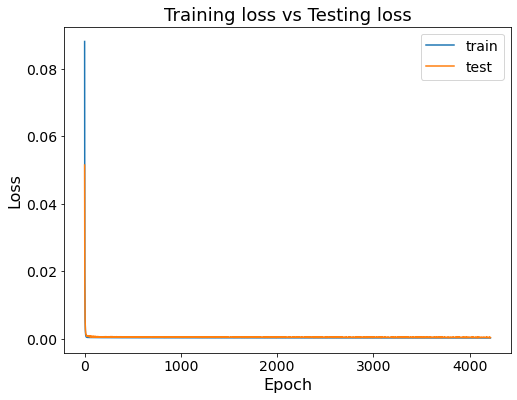

In [35]:
lr = 0.0001
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc2_4layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [ ]:
# model_load.predict(test_input).shape

### Performance

In [36]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc2_4layer_{}h.h5'.format(K))

In [37]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [38]:
# inv_y

In [39]:
# inv_yhat

In [40]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0504
RMSE = 0.0712
